In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import cv2
from tqdm.auto import tqdm
import os
from sklearn.model_selection import train_test_split

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define the Hyperparameters


In [4]:
# for local
DATA_DIR='../kaggle_fungi'
MODEL_PATH = 'model.h5'

batch_size = 8
val_batch_size = 20
epochs = 10
inner_lr = 0.02

n_way = 3
k_shot = 5
q_query = 1

input_shape = (256, 256, 3)
outer_lr = 0.001 # 0.001

## Visualize Data

In [5]:
# training v.s test Omniglot classes
all_classes = glob(DATA_DIR+'/source/*')
len(all_classes)

train_classes, val_classes = train_test_split(all_classes, test_size=0.2)
len(train_classes), len(val_classes)

(240, 60)

../kaggle_fungi/source\63728_Russula_fragilis\BTO2017-9222394_Hy_CklGn-.JPG (682, 1024, 3)


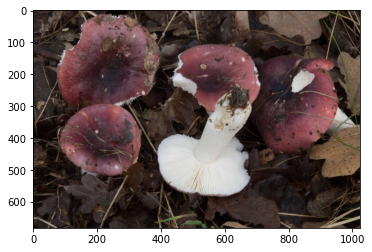

In [8]:
# 觀察圖片內容
path = np.random.choice(glob(DATA_DIR+'/source/*/*.JPG'), 1)[0]
img = cv2.imread(path)[:,:,::-1]
print(path, img.shape)
plt.imshow(img)
plt.show()

## Prepare the data

In [10]:
class MetaDataLoader:
    def __init__(self, file_list, batch_size, n_way=5, k_shot=1, q_query=1, preprocess=None):
        """
        :param data_path: 資料夾下有子資料夾
        :param batch_size: 一個批次有多少個不同的task
        :param n_way: 一個task有幾類
        :param k_shot: 一個類別中有幾張圖片用於inner loop training
        :param q_query: 一個類別中有幾張圖片用於outer loop training
        """
        self.file_list = file_list
        self.steps = len(self.file_list) // batch_size

        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.meta_batch_size = batch_size
        self.preprocess = preprocess

    def get_one_task_data(self):
        """
        取一個task, 有n_way類別,每類別有 k_shot於inner training, q_query張於outer training
        :return: support_data, query_data
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob(img_dir + "/*.JPG", recursive=True)]
            #print(img_list)
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (256, 256))
                if self.preprocess:
                    image = self.preprocess(image)
                else:
                    image = image / 255.
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (256, 256))
                if self.preprocess:
                    image = self.preprocess(image)
                else:
                    image = image / 255.
                query_data.append((image, label))

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)

    def get_one_batch(self):
        """
        取一個batch, 以task為個體
        :return: k_shot_data, q_query_data
        """

        while True:
            batch_support_image = []
            batch_support_label = []
            batch_query_image = []
            batch_query_label = []

            for _ in range(self.meta_batch_size):
                support_image, support_label, query_image, query_label = self.get_one_task_data()
                batch_support_image.append(support_image)
                batch_support_label.append(support_label)
                batch_query_image.append(query_image)
                batch_query_label.append(query_label)

            yield np.array(batch_support_image), np.array(batch_support_label), \
                  np.array(batch_query_image), np.array(batch_query_label)

preprocess = tf.keras.applications.efficientnet.preprocess_input
train_loader = MetaDataLoader(train_classes, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query, preprocess=preprocess)
val_loader = MetaDataLoader(val_classes, batch_size, n_way=n_way, k_shot=k_shot, q_query=q_query, preprocess=preprocess)

## Visualize some examples from the dataset


(15, 256, 256, 3)


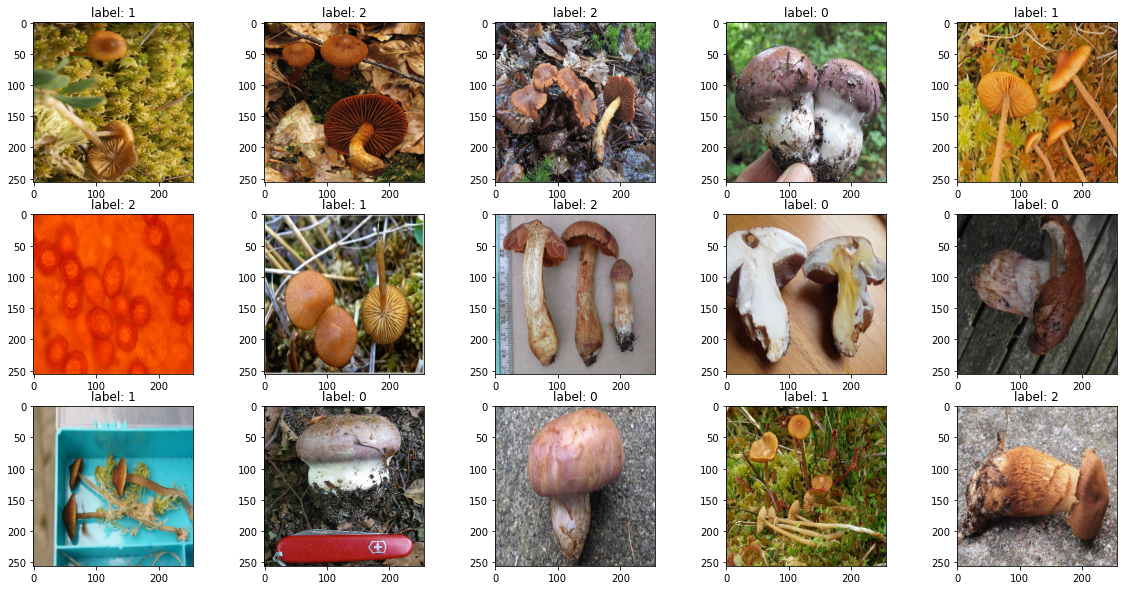

In [11]:
## Target Support 
support_imgs, support_labels, q_imgs, q_labels = val_loader.get_one_task_data()
print(support_imgs.shape)

plt.figure(figsize=(20, 10))
for i in range(len(support_imgs)):
    plt.subplot(3, 5, i+1)
    plt.title(f'label: {support_labels[i]}')
    plt.imshow(support_imgs[i].squeeze(), cmap=plt.cm.gray_r)
plt.show()

## Build the model


In [12]:
# model with pre-trained weights
base_model = keras.applications.EfficientNetB0(weights='imagenet', 
                                          input_shape=(256, 256, 3), 
                                          classes=n_way, 
                                          include_top=False)
model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(n_way, activation="softmax"),
])
# Freeze base model
for l in base_model.layers:
    l.trainable = False

inner_optimizer = keras.optimizers.SGD(learning_rate=inner_lr)
outer_optimizer = keras.optimizers.SGD(learning_rate=outer_lr)

model.compile(optimizer=inner_optimizer, 
              loss=keras.losses.sparse_categorical_crossentropy)

16711680/16705208 [==============================] - 1s 0us/step


## Train the model


In [13]:
def maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True):
    meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
    batch_acc = []
    batch_loss = []

    for support_image, support_label, query_image, query_label in zip(meta_support_image, meta_support_label, meta_query_image, meta_query_label):
        # 保存一開始model weights
        meta_weights = model.get_weights()
        # inner loop training
        for _ in range(inner_step):
            with tf.GradientTape() as tape:
                logits = model(support_image, training=True)
                loss = keras.losses.sparse_categorical_crossentropy(support_label, logits)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_variables)
            inner_optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # outer loop training: 計算query set loss
        with tf.GradientTape() as tape:
            logits = model(query_image, training=True)
            loss = keras.losses.sparse_categorical_crossentropy(query_label, logits)
            loss = tf.reduce_mean(loss)
            acc = (np.argmax(logits, -1) == query_label).astype(np.int32).mean()

            batch_loss.append(loss)
            batch_acc.append(acc)
        # 回復成一開始weights
        model.set_weights(meta_weights)

        # 在training set中需要更新 meta model
        if training:
            grads = tape.gradient(loss, model.trainable_variables)
            outer_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return np.array(batch_loss).mean(), np.array(batch_acc).mean()

## MAML

In [14]:
print(train_loader.steps, val_loader.steps)
print(len(train_loader.file_list))

30 7
240


In [15]:
train_meta_loss = []
train_meta_acc = []
val_meta_loss = []
val_meta_acc = []

epochs = 10

for meta_iter in tqdm(range(epochs)):
    # Training
    for i in tqdm(range(train_loader.steps), leave=False):
        batch_data = train_loader.get_one_batch() # batch_sup_img, batch_sup_label, batch_query_img, batch_query_label
        batch_train_loss, batch_train_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=1, training=True)
        train_meta_loss.append(batch_train_loss)
        train_meta_acc.append(batch_train_acc)
        
    print(f'[epoch {meta_iter:05d}]: train_loss: {np.mean(train_meta_loss):.4f} train_acc: {np.mean(train_meta_acc):.3f} ')
    
    # Val
    for i in tqdm(range(val_loader.steps), leave=False):
        batch_data = val_loader.get_one_batch() # batch_sup_img, batch_sup_label, batch_query_img, batch_query_label
        batch_val_loss, batch_val_acc = maml(model, batch_data, inner_optimizer, outer_optimizer, inner_step=3, training=False)
        val_meta_loss.append(batch_val_loss)
        val_meta_acc.append(batch_val_acc)
        
    print(f'[epoch {meta_iter:05d}]: val_loss: {np.mean(val_meta_loss):.4f} val_acc: {np.mean(val_meta_acc):.3f} ')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[epoch 00000]: train_loss: 1.0751 train_acc: 0.397 


  0%|          | 0/7 [00:00<?, ?it/s]

[epoch 00000]: val_loss: 0.9438 val_acc: 0.577 


  0%|          | 0/30 [00:00<?, ?it/s]

[epoch 00001]: train_loss: 1.0768 train_acc: 0.406 


  0%|          | 0/7 [00:00<?, ?it/s]

[epoch 00001]: val_loss: 0.9542 val_acc: 0.554 


  0%|          | 0/30 [00:00<?, ?it/s]

[epoch 00002]: train_loss: 1.0772 train_acc: 0.416 


  0%|          | 0/7 [00:00<?, ?it/s]

[epoch 00002]: val_loss: 0.9544 val_acc: 0.554 


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
model.save(MODEL_PATH)

##MAML_Finetune

In [17]:
def maml_finetune(model, meta_support_image, meta_support_label, meta_query_image, inner_optimizer, outer_optimizer, inner_step=1):
    #meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
    batch_acc = []
    batch_loss = []
    
    query_image = meta_query_image
    loss_fn = keras.losses.sparse_categorical_crossentropy

    # inner loop training
    for _ in range(inner_step):
        model.train_on_batch(meta_support_image, meta_support_label)

    logits = model.predict(np.expand_dims(query_image, axis=0))
    label_id = np.argmax(logits)
        
    return  label_id

In [19]:
def load_support_dataset(img_size, preprocess=None):
    sup_dataset = {}
    sup_folders = glob('../kaggle_fungi/target_s/*')
    print(len(sup_folders))
    for folder_path in tqdm(sup_folders):
        img_paths = sorted(glob(os.path.join(folder_path, '*.JPG')))
        cls_name = folder_path.split(os.sep)[-1]
        imgs = np.zeros((len(img_paths), img_size, img_size, 3))
        
        for i, img_path in enumerate(img_paths):
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_size, img_size))
            if preprocess:
                image = preprocess(image)
            imgs[i] = image
        sup_dataset[cls_name] = imgs
    return sup_dataset
        
    
sup_dataset = load_support_dataset(input_shape[0], preprocess=preprocess)    

110


  0%|          | 0/110 [00:00<?, ?it/s]

In [20]:
model = keras.models.load_model(MODEL_PATH)

In [21]:
import csv
import os

inner_step = 3
test_opt = keras.optimizers.SGD(learning_rate=inner_lr)
w = model.get_weights()
model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
              optimizer=keras.optimizers.SGD(learning_rate=inner_lr))

test_img_dir = r"../kaggle_fungi/target_q"

fileName =[]
y_ans =[]

with open(r"../kaggle_fungi/test1.csv", 'r') as f:
    myCsv = csv.reader(f)
    headers = next(myCsv)
    for i, row in enumerate(tqdm(myCsv, total=2200)):   
        model.set_weights(w)
        
        img_dirs=[]
        query_img_path = os.path.join(test_img_dir, row[0])
        image = cv2.imread(query_img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_shape[0], input_shape[1]))
        target_q = preprocess(image)

        target_s = np.concatenate((sup_dataset[row[1]], sup_dataset[row[2]], sup_dataset[row[3]]))
        target_label = np.array([0]*5+[1]*5+[2]*5)

        
        y_pred = maml_finetune(model, target_s, target_label, target_q, 
                               inner_optimizer=test_opt, 
                               outer_optimizer=None, inner_step=inner_step)
        fileName.append(row[0])
        y_ans.append(y_pred)
        

  0%|          | 0/2200 [00:00<?, ?it/s]

In [22]:
import pandas as pd

submission = pd.DataFrame({'fileName': fileName, 'ans': y_ans})

In [23]:
submission.head()

,fileName,ans
0,BEC2017-9189449_r1s5mHxpx.JPG,2
1,HODDE2013PIC30468049.JPG,2
2,AS2013PIC68471111.JPG,2
3,JM2016-9165541_r1HMvecQ.JPG,0
4,DP2016-9181037_rklmIHiEge.JPG,0


In [24]:
submission.to_csv('./my_submission_hw1.csv', index=False)

#### Results

1. VGG           10 epochs,   w/o pre-trained  0.368
2. EfficientNet  2  epochs,  w   pre-trained  0.591
3. EfficientNet  10 epochs,  w   pre-trained  0.602

#### HINT

1. Data Augmentataion
2. inner steps, inference inner steps